# Voorbewerking
Voor tijdreeksanalyse zijn grondwaterstanden en verklarende reeksen nodig. Beide komen in verschillende lengtes, frequenties en kwaliteit. In veel gevallen is een voorbewerking van de reeksen nodig. In dit notebook wordt geïllustreerd welke bewerkingen je kan doen en wanneer deze nodig zijn.  Onderstaande voorbeelden worden uitgewerkt: 



**Inhoudsopgave**


- [Opschonen stijghoogte reeks](#Opschonen-stijghoogte-reeks)
- [Vereenvoudigen stijghoogte reeks](#Vereenvoudigen-stijghoogte-reeks)
- [Equidistant maken verklarende reeks](#Equidistant-maken-verklarende-reeks)
- [Opvullen verklarende reeks](#Opvullen-verklarende-reeks)
- [Synchroniseren verklarende reeks](#Synchroniseren-verklarende-reeks)
- [Normaliseren peil](#Normaliseren-peil)
- [Eenheden afstemmen](#Eenheden-afstemmen)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

from matplotlib.gridspec import GridSpec

ps.set_log_level("ERROR")
#ps.show_versions()
%config InlineBackend.figure_format = 'svg'

## Opschonen stijghoogte reeks
Het doel van tijdreeksanalyse is een grondwaterstands of stijghoogte reeks te verklaren uit invoerreeksen. Door middel van automatische optimalisatie probeert de software de reeks zo dicht mogelijk te benaderen. Wanneer er fouten in de reeks aanwezig zijn kan dat grote gevolgen hebben voor de kwaliteit van het model. 
Onderstaand voorbeeld geeft een model dat is geoptimaliseerd zonder een duidelijke uitbijter te verwijderen. 

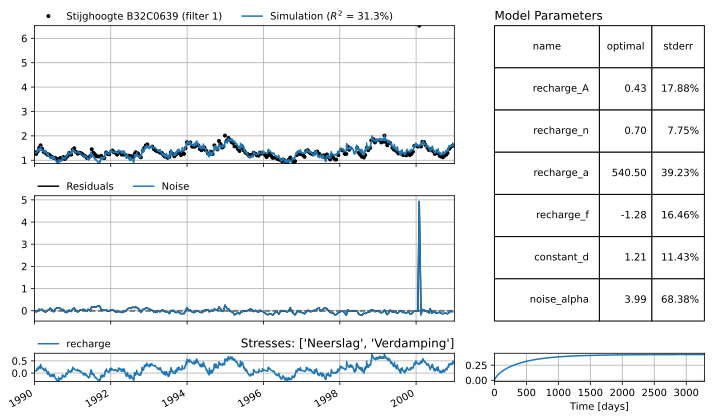

In [2]:
# Read data
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"
head = pd.read_csv("data/B32C0639001_changed.csv",  parse_dates=['date'], index_col='date', squeeze=True)
head.name = "Stijghoogte B32C0639 (filter 1)"

# Create the basic Pastas model
ml = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(rm)

# Solve the model
tmin = "1990"
tmax = "2001"

ml.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()



De resultaten van dit model zijn niet erg bemoedigend. De verklaarde variantie bedraagt slechts 31%. Dit komt mede door de grote afwijking bij de uitbijter,  maar ook de standaard-fouten van de parameters zijn relatief groot en de responstijd van de neerslag en verdamping lijkt voor nederlandse begrippen aan de hoge kant.   
We gaan nu kijken wat de resultaten worden als we de uitbijter verwijderen. 

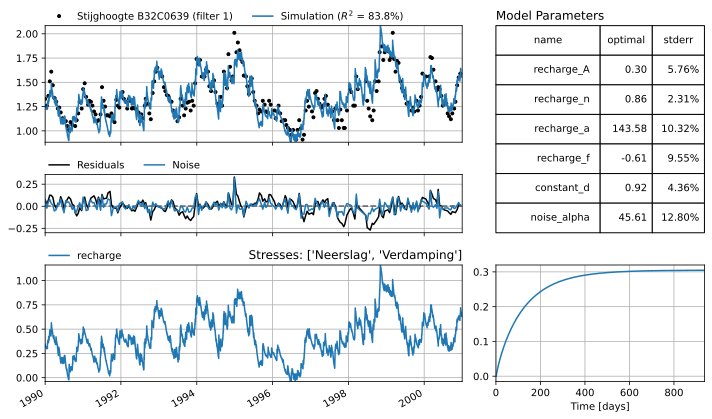

In [3]:
# remove outlier
head[head > 4] = np.nan

# Create the basic Pastas model
ml = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(rm)

# Solve the model
tmin = "1990"
tmax = "2001"

ml.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()


In bovenstaande figuur is te zien dat het model veel beter presteert met de opgeschoonde reeks. Het blijkt dat de uitbijter (ook als is het er maar één) een grote nvloed heeft op het resultaat. Naast een betere fit (84%), zijn ook de standaardfouten kleiner en is de respons korter geworden.     

## Vereenvoudigen stijghoogte reeks
Sommige reeksen bevatten zeer hoogfrequente data, met bijvoorbeeld een tijdstap van een uur of nog korter. Afhankelijk van het doel van de tijdreeksanalyse en de beschikbare invoer, kan het gewenst zijn om de reeksen te aggregeren of uit te dunnen. Hier geven we een voorbeeld van deze situatie. 

%% Voorbeeld van een hoogfrequente reeks (uurwaarden met getij), waar we een berekening doen met en zonder uitgedunde/geaggregeerde reeks

In [77]:
head = pd.read_csv("data/PB_5_001_04P001442_F-909.csv", index_col=0, parse_dates=True, squeeze=True).resample("H").mean().dropna()
prec = pd.read_csv("data/RD Petten.csv", index_col=0, parse_dates=True)
evap = pd.read_csv("data/EV24 De Kooy.csv", index_col=0, parse_dates=True)
sea = pd.read_csv("data/Den Helder.csv", index_col=0, parse_dates=True)

# ml = ps.Model(head, name="hourly")
# ml.settings["freq"] = "H"
# rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma)
# ml.add_stressmodel(rm)
# sm = ps.StressModel(sea - sea.mean(), ps.Exponential, "sealvl",
#                         settings="waterlevel")
# ml.add_stressmodel(sm)
# #ml.solve(noise=False, report=False, tmin="2015-04-01")
# ml.solve(initial=False, tmin="2015-04-01")

# ml.plots.results(figsize=(10, 6), adjust_height=True);
# plt.tight_layout()

# ml = ps.Model(head, name="daily")
# rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma)
# ml.add_stressmodel(rm)
# sm = ps.StressModel(sea - sea.mean(), ps.Exponential, "sealvl",
#                         settings="waterlevel")

# ml.add_stressmodel(sm)
# #ml.solve(noise=False, report=False, tmin="2015-04-01")
# ml.solve(initial=False, tmin="2015-04-01")
# ml.plots.results(figsize=(10, 6), adjust_height=True);
# plt.tight_layout()


ml = ps.Model(head, name="daily")
rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma)
ml.add_stressmodel(rm)
sm = ps.StressModel(sea - sea.mean(), ps.Exponential, "sealvl",
                        settings="waterlevel")
ml.add_stressmodel(sm)
#ml.solve(noise=False, report=False, tmin="2015-04-01")
ml.solve(tmin="2015-04-01")
ml.plots.results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()




Fit report daily                  Fit Statistics
nfev     41                     EVP           60.00
nobs     1511                   R2             0.60
noise    True                   RMSE           0.11
tmin     2015-04-01 00:00:00    AIC           10.21
tmax     2019-10-16 10:00:00    BIC           52.77
freq     D                      Obj            0.16
warmup   3650 days 00:00:00     ___                
solver   LeastSquares           Interpolated    Yes

Parameters (8 were optimized)
                optimal    stderr     initial  vary
recharge_A    12.539347    ±1.30%  204.757284  True
recharge_n     2.102682    ±0.78%    1.000000  True
recharge_a     1.693313    ±1.52%   10.000000  True
recharge_f    -0.014130  ±271.72%   -1.000000  True
sealvl_A       6.205088   ±11.01%    1.751523  True
sealvl_a     354.298135   ±11.07%   10.000000  True
constant_d     0.769313    ±0.95%    0.820438  True
noise_alpha  117.369011    ±6.41%    1.000000  True

Parameter correlations |rho| > 0.5


## Equidistant maken verklarende reeks
Voor de meeste tijdreeksanalyseprogramma's is het nodig dat de verklarende reeksen gelijke tijdstappen hebben, ofwel equidistant zijn. In sommige gevallen worden ze zo aangeleverd. Als dat niet zo is, is het nodig om de reeksen equidistant te maken. De manier waarop dit gebeurt, hangt af van het type verklarende reeks. Rivierpeilen kunnen bijvoorbeeld geïnterpoleerd worden afhankelijk van de grootte van de tijdstap en de dynamiek van de reeks. Bij onttrekkingsreeksen moet men zich afvragen of een missende waarde betekent dat de onttrekking uit stond, of dat er gegevens ontbreken omdat er geen waarneming heeft plaatsgevonden. Het opvullen van de data introduceert onzekerheden, die niet automatisch worden meegenomen in de analyse. Men kan erook voor kiezen de tijdstap van de tijdreeksanalyse te vergroten, wanneer dat beter bij de resolutie van de beschikbare gegevens past. 

In [54]:
from IPython.display import IFrame

IFrame(.ipynb_checkpointsrc='https://s3.amazonaws.com/duhaime/blog/visualizations/isolation-forests.html', width=700, height=600)

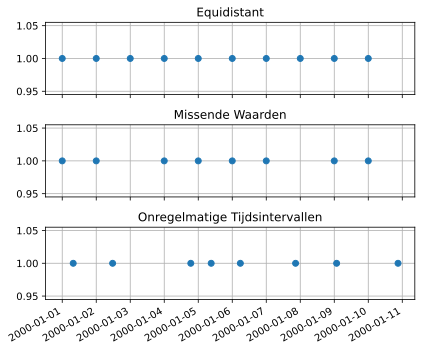

In [45]:
# Voorbeeld van Raoul met onttrekkingdsdata  
regular = pd.Series(index=pd.date_range("2000-01-01", "2000-01-10", freq="D"),
                   data=np.ones(10))
missing_data = regular.copy()
missing_data.loc[["2000-01-03", "2000-01-08"]] = np.nan

index = [t + pd.Timedelta(np.random.rand()*24, unit="H") for t in missing_data.index]
irregular = missing_data.copy()
irregular.index = index

fig, axes = plt.subplots(3,1, figsize=(6, 5), sharex=True, sharey=True)

regular.plot(ax=axes[0], linestyle=" ", marker="o", x_compat=True)
missing_data.plot(ax=axes[1], linestyle=" ", marker="o", x_compat=True)
irregular.plot(ax=axes[2], linestyle=" ", marker="o", x_compat=True)

for i, name in enumerate(["Equidistant", "Missende Waarden", "Onregelmatige Tijdsintervallen"]):
    axes[i].grid()
    axes[i].set_title(name)
plt.tight_layout()


## Opvullen verklarende reeks
%% Voorbeeld met opvullen van onttrekkingsdata   (gemiddelde ervoor, of nullen ervoor)

In [6]:
# Voorbeeld met opvullen van onttrekkingsdata   (gemiddelde ervoor, of nullen ervoor)

## Synchroniseren verklarende reeks
Bij tijdreeksanalyse worden reeksen vergeleken op tijdstapniveau. Het is van belang dat de definitie van de reeksen van dezelfde tijd uitgaan. Dit lijkt evident, maar toch is dit iets wat in de praktijk mis kan gaan. Zo zullen soms correcties ingevoerd moeten worden om de reeksen synchroon te maken voor tijdreeksanalyse. Het volgende voorbeeld behandelt een geval waarbij synchronisatie noodzakelijk is om een goed tijdreeksmodel te kunnen maken.  

%% Voorbeeld van model onttrekkingsdata (maand) die met een tellerstand op de laatste dag is gelogd. 

In [7]:
# Voorbeeld van model onttrekkingsdata (maand) die met een tellerstand op de laatste dag is gelogd. 

In [9]:
#sm2.stress[0].settings

## Normaliseren peil
Wanneer een verklarende reeks een peil betreft (bijvoorbeeld van een nabij gelegen rivier) is het een goed idee om het peil te normaliseren zodat de reeks rond 0 schommelt. Dit kan eenvoudig door het gemiddelde of de mediaan van de reeks af te trekken. Onderstaand voorbeeld laat zien hoe de resultaten dan verbeteren.  

%% Voorbeeld van model met rivier, wel en niet genormaliseerd

In [10]:
# Voorbeeld van model met rivier, wel en niet genormaliseerd

head = pd.read_csv("data/40CP0393-004.csv", index_col=0, parse_dates=True, squeeze=True).resample("D").mean().dropna()
prec = pd.read_csv("data/RD_Nijmegen.csv", index_col=0, parse_dates=True) * 1e3
evap = pd.read_csv("data/EV24_Deelen.csv", index_col=0, parse_dates=True) * 1e3

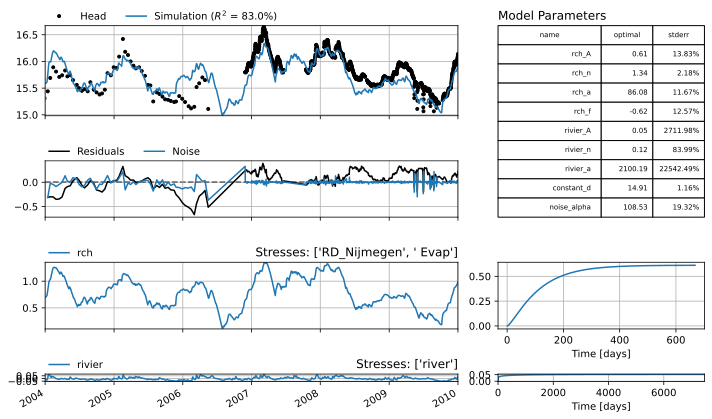

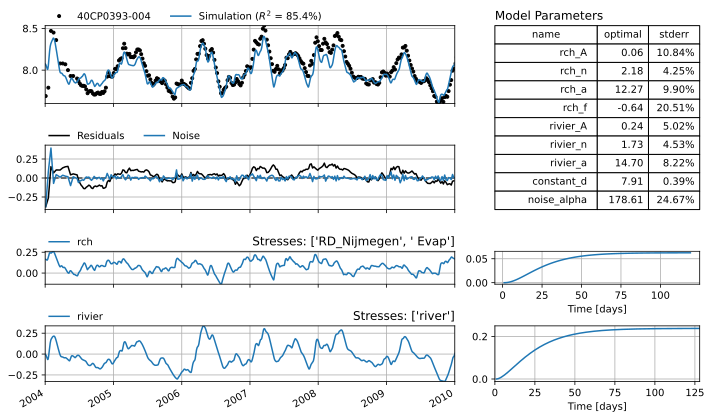

In [41]:
rivier = pd.read_csv("data/40CP0393-rivier_vanaf2000.csv", index_col=0, parse_dates=True, squeeze=True)
ml = ps.Model(head, name="40CP0393 (filter 4)")
sm = ps.RechargeModel(prec, evap, name="rch", recharge=ps.rch.Linear(), rfunc=ps.Gamma)
ml.add_stressmodel(sm)

sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Gamma)
ml.add_stressmodel(sm2)
ml.solve(tmin="2004", tmax="2010", report=False)
ml.plots.results(figsize=(10, 6), tmin="2004", tmax="2010", adjust_height=True);
plt.tight_layout()

head = pd.read_csv("data/40CP0393-004.csv", index_col=0, parse_dates=True, squeeze=True).resample("W").mean().dropna()

ml = ps.Model(head, name="40CP0393 (filter 4)")
sm = ps.RechargeModel(prec, evap, name="rch", recharge=ps.rch.Linear(), rfunc=ps.Gamma)
ml.add_stressmodel(sm)

sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Gamma)
ml.add_stressmodel(sm2)
ml.solve(tmin="2004", tmax="2010", report=False)
ml.plots.results(figsize=(10, 6), tmin="2004", tmax="2010", adjust_height=True);
plt.tight_layout()


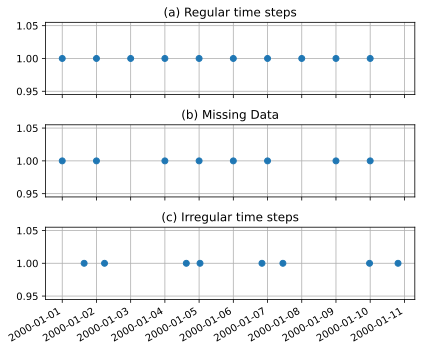

## Eenheden afstemmen
Voor de interpretatie van de resultaten (en soms ook voor het succes van de kalibratie) is het gewenst om de eenheden van de verschillende reeksen goed te kiezen en eventueel op elkaar af te stemmen.   
In onderstaand voorbeeld proberen we de invloed van een onttrekking vast te stellen. De invoer is aangeleverd op dagbasis in standaardeenheden. Neerslag en verdamping worden geleverd  in meters per dag, en de onttrekking in kubieke meters per dag. We zijn geïnteresseerd in het het totaal-effect van de onttrekking ter hoogte van de waarnemingsput. Eerst doen we eeen tijdreeksanalyse met de eenheden zoals we die zijn aangeleverd: 

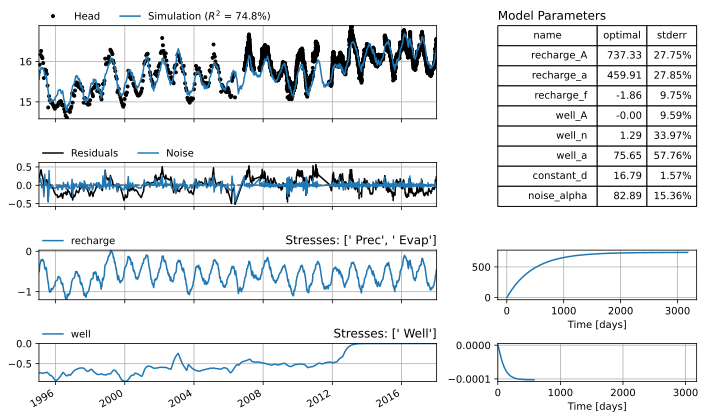

In [35]:
# Voorbeeld met verschillende eenheden, waardoor de gain niet te interpreteren is. 
# Verandering naar een goed voorbeeld waar dat wel kan. 
head = pd.read_csv("data/head_wellex.csv", index_col="Date", parse_dates=True, squeeze=True)
rain =  pd.read_csv("data/prec_wellex.csv", index_col="Date", parse_dates=True) #dagwaarden m/d
evap =  pd.read_csv("data/evap_wellex.csv", index_col="Date", parse_dates=True) #dagwaarden m/d
well =  pd.read_csv("data/well_wellex.csv", index_col="Date", parse_dates=True) #dagwaarden m3/d
ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential, recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
sm = ps.StressModel(well, rfunc=ps.Gamma, name="well", settings="well", up=False)
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False, fit_constant='True')
ml.plots.results(figsize=(10, 6), adjust_height=True);


Het effect van de put (de "gain") is gelijk aan de parameter well_A in de tabel. Deze heeft de eenheid van stijghoogte gedeeld door de eenheid van de onttrekking. In dit geval is dat dus een verlaging (in meter) bij een onttrekking van één kubieke meter per dag. Vanzelfsprekend is dat een heel klein getal, en in de tabel wordt dit zelfs afgerond naar 0.00. De gain van de recharge stelt de stijghoogte-verhoging voor die zou ontstaan als het continu één meter per dag zou regenen (737 meter). Evenzo is de verlaging door één meter verdamping per dag gelijk aan 1.86*737 = 1370 meter. Deze eenheden zijn niet erg praktsch voor de interpretatie. Daarom doen we deze tijdreeksanalyse nog eens opnieuw, maar dan veranderen we de eenheden van verdamping en neerslag naar mm/dag, en de onttrekking in miljoen kubieke meters per jaar.  
  

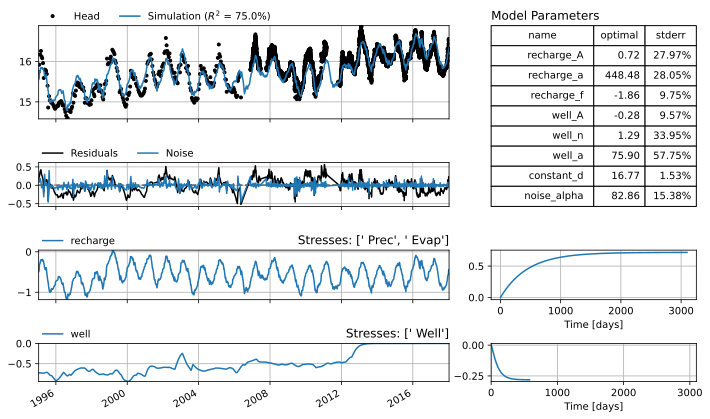

In [38]:
# Voorbeeld met verschillende eenheden, waardoor de gain niet te interpreteren is. 
# Verandering naar een goed voorbeeld waar dat wel kan. 
head = pd.read_csv("data/head_wellex.csv", index_col="Date", parse_dates=True, squeeze=True)
rain =  pd.read_csv("data/prec_wellex.csv", index_col="Date", parse_dates=True) * 1e3
evap =  pd.read_csv("data/evap_wellex.csv", index_col="Date", parse_dates=True) * 1e3
well =  pd.read_csv("data/well_wellex.csv", index_col="Date", parse_dates=True) * 365.25/ 1e6

ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential, recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
sm = ps.StressModel(well, rfunc=ps.Gamma, name="well", settings="well", up=False)
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False, fit_constant='True')
ml.plots.results(figsize=(10, 6), adjust_height=True);

Bovenstaande figuur toont de resultaten met de gewijzigde eenheden. Wat opvalt is dat ook na omrekening de getallen iets verschillen. Dit zijn afwijkingen die ontstaan bij de optimalisatie van de parameters, die nu iets anders verloopt omdat de verhoudingen tussen de invoerreeksen verschillen. De gain bij één millimeter neerslag per dag  is nu 0.72 meter. De verlaging ten gevolge van een onttrekking van één miljoen kuub per jaar is 0.28 meter. Om de eindverhoging bij stopzetting van de winning te schatten moet deze waarde vermenigvuldigd worden met de werkelijke wincapaciteit. (in miljoen kuub per jaar). Wanneer het een winning van 2 miljoen kuub per jaar betreft, zal de verhoging dus 56 centimeter zijn.       